In [1]:
import numpy as np 
import astropy.constants as c
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import gc
import math
#list all the constants used
G=c.G.value
M_sun=c.M_sun.value
M_earth=c.M_earth.value
R_sun=c.R_sun.value
R_earth=c.R_earth.value
hour=3600 #s
day=3600*24
e=0.1
t_LC=1765.5 #s

def delta(Rp, Rs): #unit ppm
    delta = (Rp*R_earth / (Rs*R_sun))**2*1e6
    return delta

def SNR(delta,n,sigma_s):
    SNR=delta*n**0.5/sigma_s
    return SNR

def sigma_s(t, sigma_LC, cdppindex): #t/hour
    t_LC=1765.5/hour 

    return sigma_LC*(t/t_LC)**cdppindex

def t_dur(P,Rs,e,a): #hour
    t_dur = P*day*Rs*R_sun*(1-e**2)/(np.pi*a)/hour
    return t_dur

def a(Ms,P):
    a=((G*Ms*M_sun*(P*day)**2)/(4*np.pi**2))**(1/3)
    return a 

def n(t_obs,P): # the unite of t_obs and P is day
    n=t_obs/P
    return n

def f_n(t_obs,P):
    if t_obs <=2*P:
        return 0
    if t_obs> 2*P and t_obs< 3*P:
        return (t_obs/P-2)
    if t_obs>=3*P:
        return 1
    
def f_eff(SNR):
    if SNR <=6:
        return 0
    if SNR >6 and SNR<=12:
        return (SNR-6)/6
    if SNR>12:
        return 1
    
def f_geo(Rp,Rs,a,e):
    f_geo = (Rp*R_earth+Rs*R_sun)/(a*(1-e**2))
    return f_geo


364.98242 0.259819659
[0.259819659, 0.34184201700000005, 0.352515897, 0.469334634, 0.494247662, 0.523632451, 0.524175803, 0.558841234, 0.567856484, 0.568874717]
[0.259819659, 0.66682654, 0.8930409690000001, 0.998212785, 1.284241817, 1.538180949, 1.74610057, 2.032319072, 2.252976718, 2.494170338, 2.613020421, 2.820190603, 3.036208739, 3.25058201, 3.40165617, 3.6014653360000004, 3.75574267, 3.93276627, 4.13443512, 4.24263096, 4.4096675, 4.5513987999999985, 4.69505576, 4.822969318, 4.99677968, 5.18560081, 5.34264143, 5.47455167, 5.65178922, 5.78159956, 5.9022457820000005, 6.11784972, 6.36283414, 6.51112385, 6.77367892, 6.93650854, 7.05429483, 7.19304935, 7.36272124, 7.61758198, 7.8687122999999985, 8.08801663, 8.27745764, 8.46354384, 8.710442022, 8.981014925, 9.30413878, 9.65349016, 9.98970266, 10.28194593, 10.47548084, 10.81315417, 11.1317901, 11.47609015, 11.79161234, 12.0729757, 12.4128518, 12.75934489, 13.07141889, 13.48457668, 13.82142084, 14.28228147, 14.74914825, 15.2311195, 15.9314

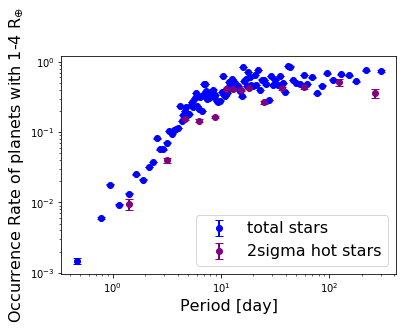

In [2]:
#等数量bin和等间隔bin差距这么大?哪一个才是真实的呢

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
#bins_period=np.logspace(math.log(0.4,10),math.log(400,10),25,base=10)

period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
number=104
interval=20
bins_period=[]
period.sort()
print(max(period),min(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)

bins_radius=np.logspace(-1.5,5.5,15,base=2)  


bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_tot_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p1=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p1.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p1.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p1,f_p1,yerr=f_p_std,fmt="o",color='blue',elinewidth=2,capsize=4,label='total stars') 


stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
#bins_period=np.logspace(math.log(0.4,10),math.log(400,10),25,base=10)

period=[]
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE' \
    and koi_table['koi_prad'][j]<=4 and koi_table['koi_prad'][j]>=1 and koi_table['koi_period'][j]<=365:
        period.append(koi_table['koi_period'][j])
        
#print(period,len(period))

number=14
interval=10
bins_period=[]
period.sort()
print(max(period),min(period),len(period))
print(period[0:10])
for i in range(0,int(number)):
    bins_period.append(period[int(i*interval)])

bins_period.append(max(period))
print(bins_period)


bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p2=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp)/np.log10(bins_period[i+1]/bins_period[i]))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p2.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p2,f_p2,yerr=f_p_std,fmt="o",color='purple',elinewidth=2,capsize=4,label='2sigma hot stars') 


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Occurrence Rate of planets with 1-4 R$_{\oplus}$',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2sigma_total_1_4Rearth_p_365_quantity_new.eps') #等数量取bin

#s1=stats.ks_2samp(f_p1,f_p2)

#fig=plt.figure()
#plt.plot(koi_table['koi_period'],koi_table['koi_prad'],'.')
#plt.xscale('log')
#plt.yscale('log')


In [ ]:
def borken_powerlaw(p,p0,index1,index2):
    if p<p0:
        return (p/p0)**index1
    elif p>p0:
        return (p/p0)**index2

In [5]:
stellar_table=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
print(len(stellar_table))


113942


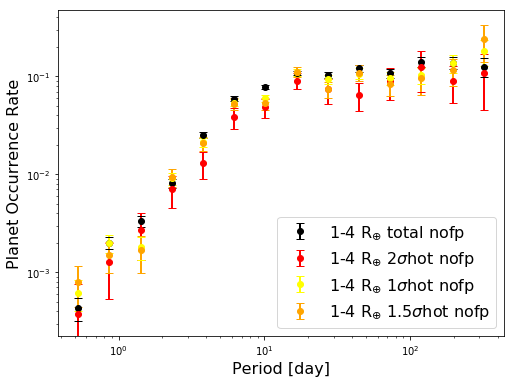

In [17]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  

fig=plt.figure(figsize=(8,6))
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)

focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_tot_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']

bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_tot_2020_2sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
number=50


a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    


f_p1=[]
f_p_std=[]
p1=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p1.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p1.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
 
plt.errorbar(p1,f_p1,yerr=f_p_std,fmt="o",color='black',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ total nofp') 
#########################################################################################################

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/result/occurrence_rate_hot_2020.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p,f_p2,yerr=f_p_std,fmt="o",color='red',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ 2$\sigma$hot nofp') 

############################################################################################

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_1sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1sigma/result/occurrence_rate_hot_2020_1sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p1=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p1.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p1,f_p2,yerr=f_p_std,fmt="o",color='yellow',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ 1$\sigma$hot nofp') 
############################################################################################

stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1.5sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_hot_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1.5sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_1d5sigma_hot.csv',sep=',')
bins_period=np.logspace(math.log(0.4,10),math.log(400,10),15,base=10)
bins_radius=np.logspace(-1.5,5.5,15,base=2)  
bins_t=np.logspace(math.log(120,5),math.log(6000,5),30,base=5)
focc=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_1.5sigma/result/occurrence_rate_hot_2020_1d5sigma.csv')
f_occurrence_everyplanet=focc['occurrence_rate']
f_id=focc['i']
bins_a_ratio=np.logspace(math.log(0.8,10),math.log(600,10),15,base=10)
a_koi_ratio=[] #use a/R_star dimensionless variance to show the correlation
for i in range(0,len(f_occurrence_everyplanet)):
    a_koi_ratio.append(a(koi_table['mass'][i],koi_table['koi_period'][i])/c.au.value*c.au.value/(koi_table['rad_b2018'][i]*c.R_sun.value))    

f_p2=[]
f_p_std=[]
p2=[]
p_std=[]
a_ratio=[]
a_ratio_std=[]
# and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
for i in range(0,len(bins_period)-1):
    focc_temp=[]
    a_ratio_temp=[]
    p_temp=[]
    
    for j in range(0,len(f_occurrence_everyplanet)):
        if koi_table['koi_period'][f_id[j]]<bins_period[i+1] and koi_table['koi_period'][f_id[j]]>=bins_period[i] and koi_table['koi_disposition'][f_id[j]]!='FALSE POSITIVE' \
        and koi_table['koi_prad'][f_id[j]]<=4 and koi_table['koi_prad'][f_id[j]]>=1 and koi_table['koi_period'][f_id[j]]<=365:
            focc_temp.append(f_occurrence_everyplanet[j])
#            a_ratio_temp.append(a_koi_ratio[f_id[j]])
            p_temp.append(koi_table['koi_period'][f_id[j]])
            
    f_p2.append(np.sum(focc_temp))
    f_p_std.append(np.sum(focc_temp)/len(focc_temp)**0.5)
    p2.append((bins_period[i+1]+bins_period[i])/2)
    p_std.append(np.std(p_temp))
#    a_ratio.append((bins_a_ratio[i+1]+bins_a_ratio[i])/2)
#    a_ratio_std.append(np.std(a_ratio_temp))
    
plt.errorbar(p2,f_p2,yerr=f_p_std,fmt="o",color='orange',elinewidth=2,capsize=4,label='1-4 R$_{\oplus}$ 1.5$\sigma$hot nofp') 

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [day]', fontsize=16)
plt.ylabel('Planet Occurrence Rate',fontsize=16,)
plt.legend(loc='best',fontsize=16)
plt.savefig('result/p_2sigma_total_1_4Rearth_p_365_interval_nofp_hot_cool_tot_new.eps')


In [18]:
stellar_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')
koi_table=pd.read_csv('/media/dyz/dyz/mywork/gaia_kepler/script/kepler_candidates_2d/main_sequence_2sigma/data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

count=0
for j in range(0,len(koi_table)):
    if koi_table['koi_disposition'][j]!='FALSE POSITIVE':
        count+=1
        
print(count)

2695
